In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
# Vestas Power Curve
P = [0,40,100,370,650,895,1150,1500,1850,2375,2900,3525,4150,4875,5600,6350,7100,7580,7800,7920,8000] # kW
v = np.arange(3,13.5,0.5) # m/s
f = interpolate.interp1d(v, P, 'cubic', fill_value = 'extrapolate')

def singlepc(v):
    v = abs(v)
    return 0.*(v<=3) + f(v)*(v>3)*(v<=13) + 8000.*(v>13)*(v<=25) + 0.*(v>25)

def gaussian(v,v0):
    sigma = 2.9 # experiment
    return np.exp(-0.5*((v-v0)/sigma)**2)/sigma/np.sqrt(2*np.pi)

def multipc(v0):
    return integrate.quad_vec(lambda v: singlepc(v)*gaussian(v,v0), -np.inf, np.inf)[0]

In [3]:
wind_ninja = pd.read_csv('data/wind/ninja_wind_56.4000_6.8000_corrected.csv',
                         sep = ',',
                         index_col = 0,
                         usecols = [0,2,3],
                         comment = '#')
v = wind_ninja['wind_speed'].values/wind_ninja['wind_speed'].mean()*10.63 # m/s global wind atlas
P = multipc(v)
cf_wind = P/8000
cf_wind.mean()

0.6439251977266333

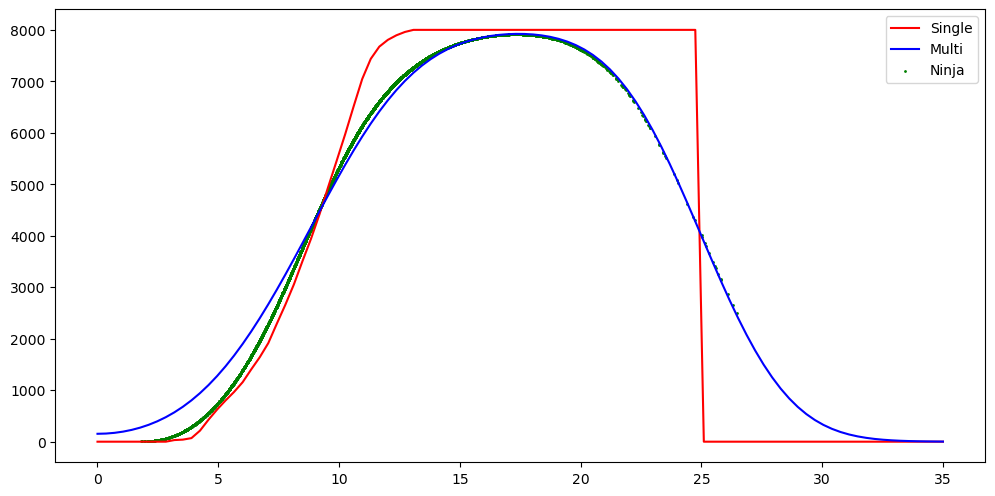

In [5]:
x = np.linspace(0,35,100)
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(x, singlepc(x), c = 'r', label = 'Single')
plt.plot(x, multipc(x), c = 'b', label = 'Multi')
plt.scatter(wind_ninja['wind_speed'], wind_ninja['electricity'], s = 1, c = 'g', label = 'Ninja')
plt.legend()
plt.show()

In [9]:
#%% Data from Global Solar Atlas (Tilt:40deg Azimuth:180deg 8000kW)
G_atlas = 1205.9 # kWh/m² 
P_atlas = 7.954E6 # kWh
A_atlas = P_atlas/G_atlas # Area [m²]

#%% Data from renewables.ninja
beta = 40 # deg (Tilt angle)
# Power production [kW]
pv_ninja = pd.read_csv('data/solar/ninja_pv_56.4000_6.8000_uncorrected.csv',
                       sep = ',',
                       index_col = 0,
                       usecols = [0,2,3,4],
                       comment = '#')
el_pv = pv_ninja['electricity'].values

# Direct (B) and Diffuse (D) irradiance (kW/m²)
B_tilt = pv_ninja['irradiance_direct'].values
D_tilt = pv_ninja['irradiance_diffuse'].values

# Ground-level solar irradiance (kW/m²)
G_0 = pd.read_csv('data/solar/Global_irr_pv_56.4000_6.8000.csv',
                  sep = ',',
                  index_col = 0,
                  usecols = [0,2],
                  comment = '#')['radiation_surface'].values/1000

# Albedo (R) (kW/m²)
rho = 0.2 # Reflectivity on the type of ground (approx. 0.2?)
R_tilt = rho*G_0*(1-np.cos(np.deg2rad(beta)))/2

# Global irradiance on tilted panels (kW/m²)
G_tilt = B_tilt+D_tilt+R_tilt
G_tilt = G_tilt/G_tilt.mean()*G_atlas/8760 # Correcting Global irradiance

# Area m²
A_ninja = np.divide(el_pv, G_tilt, out = np.zeros_like(el_pv), where = G_tilt!=0)

#%% theta_s
days = 365 # Number of days in a year
phi = 56.4 # Latitude 
xi = 6.8 # Longitude
alpha = 0 # Panel orientation angle towards south
d_n = np.arange(1,days+1)
d_n = np.repeat(d_n,24) # Number of the day
LT = np.arange(0,24)
LT = np.tile(LT,days) # Hour of day in UTC

B = (d_n-81)*360/364
ET = 9.87*np.sin(2*np.deg2rad(B))-7.53*np.cos(np.deg2rad(B))-1.5*np.sin(np.deg2rad(B))
ST = LT+(ET/60)-(xi/15)
omega = 15*(ST-12)
delta = 23.45*np.sin(np.deg2rad(360*(d_n+284)/365))

costheta_s = (np.sin(np.deg2rad(delta))*np.sin(np.deg2rad(phi))*np.cos(np.deg2rad(beta))
              -np.sin(np.deg2rad(delta))*np.cos(np.deg2rad(phi))
              *np.sin(np.deg2rad(beta))*np.cos(np.deg2rad(alpha))
              +np.cos(np.deg2rad(delta))*np.cos(np.deg2rad(phi))
              *np.cos(np.deg2rad(beta))*np.cos(np.deg2rad(omega))
              +np.cos(np.deg2rad(delta))*np.sin(np.deg2rad(phi))
              *np.sin(np.deg2rad(beta))*np.cos(np.deg2rad(alpha))*np.cos(np.deg2rad(omega))
              +np.cos(np.deg2rad(delta))*np.sin(np.deg2rad(alpha))
              *np.sin(np.deg2rad(omega))*np.sin(np.deg2rad(beta)))
costheta_s[costheta_s<0] = 0

i = np.argmax(costheta_s, axis = 0) # Index with largest value
A = A_ninja[i] # Largest PV area in ninja
P_pv = G_tilt*A_atlas
cf_pv = P_pv/8000
cf_pv.mean()

0.11349885844748861